In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of ranges of range [0, 1],
# we transform them to Tesnsor of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_data = torchvision.datasets.CIFAR10(
    root="../data", train=True, download=True, transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root="../data", train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

In [ ]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

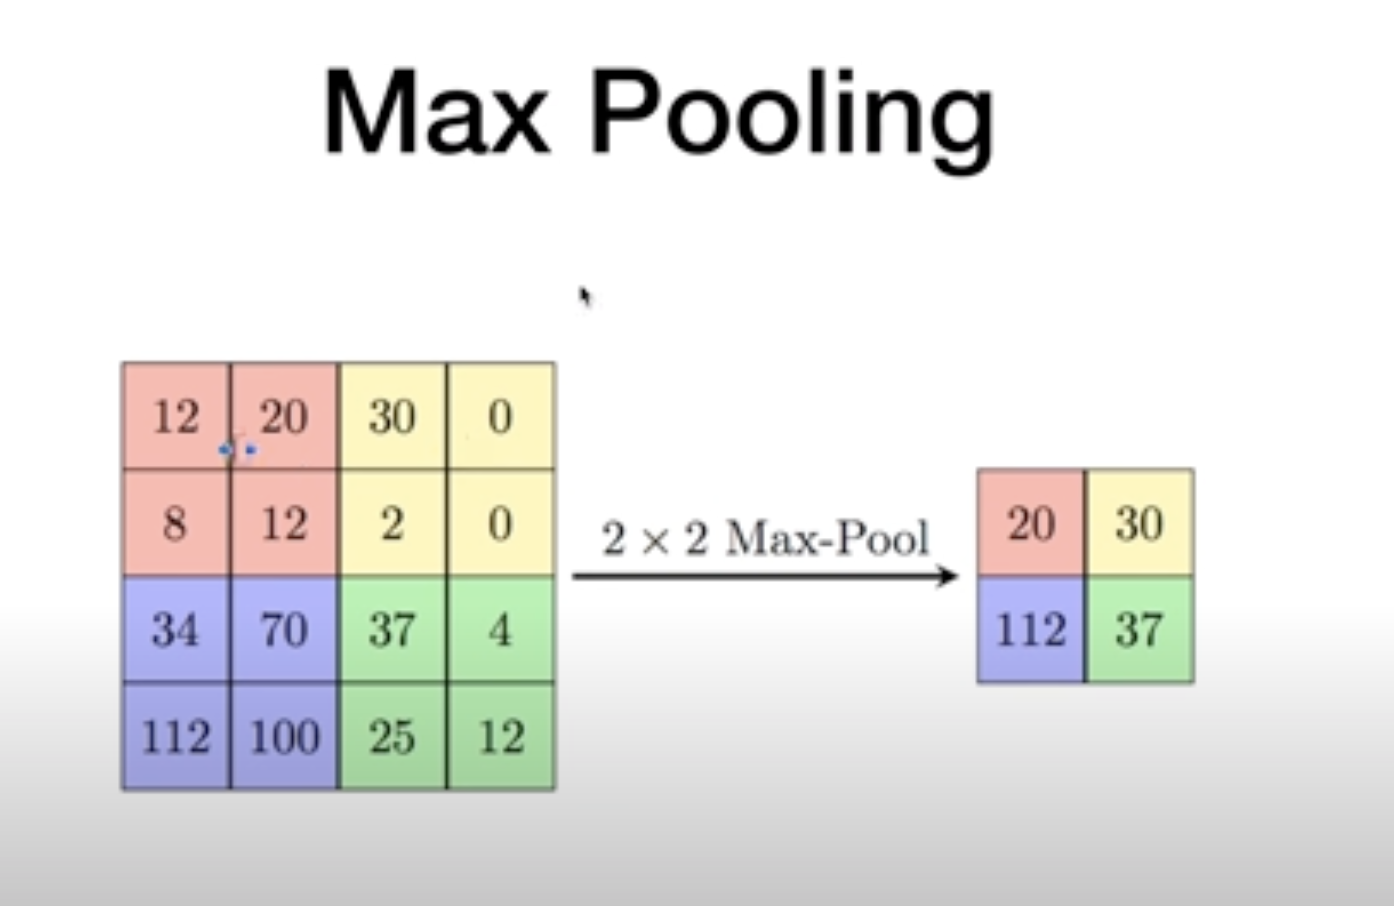

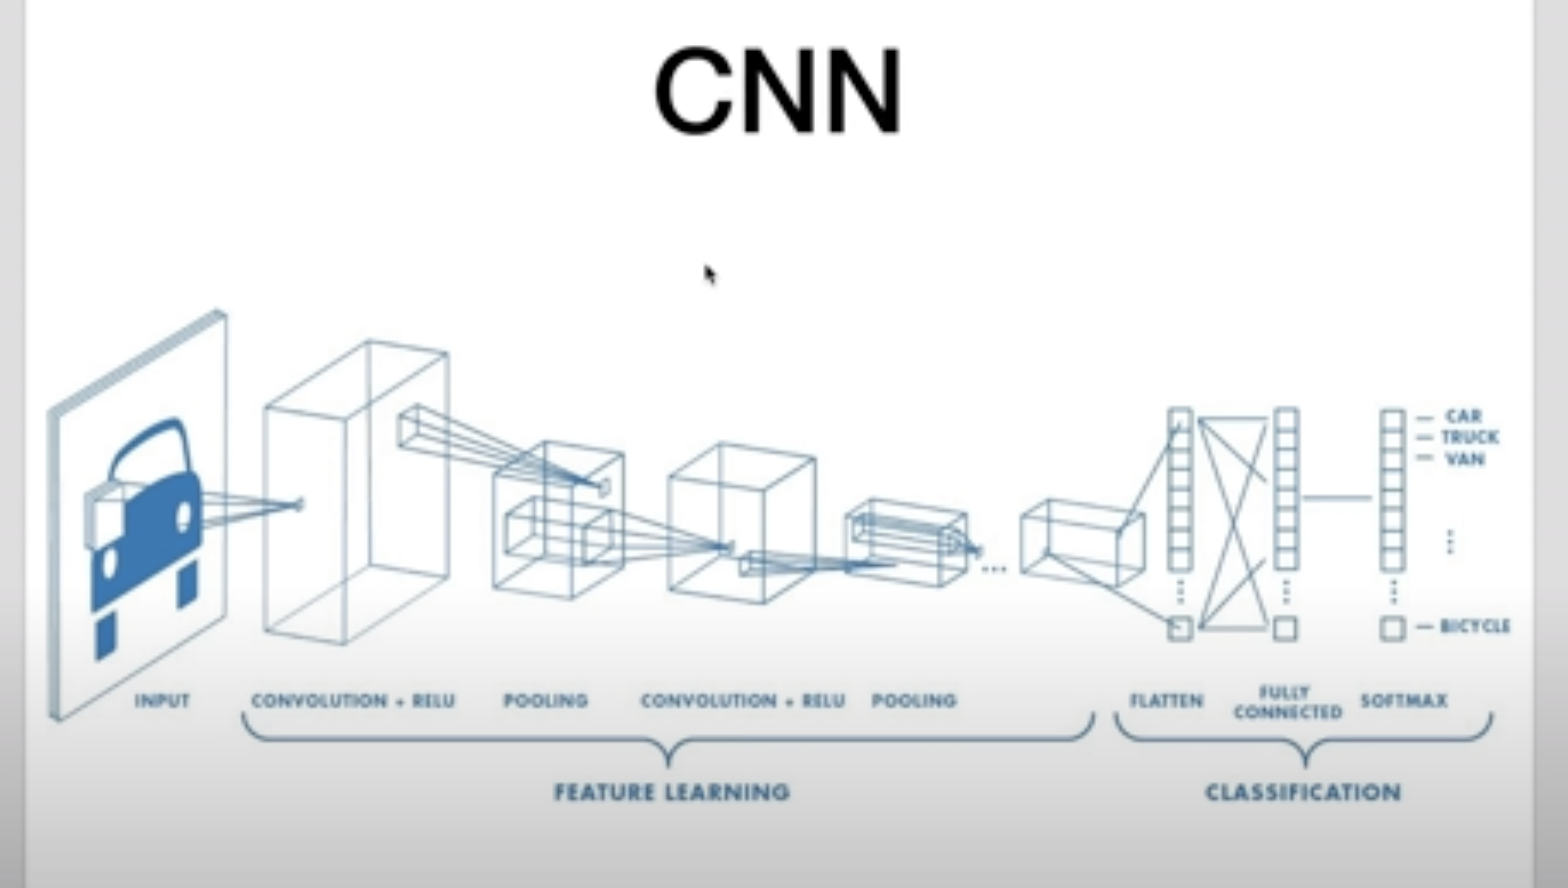

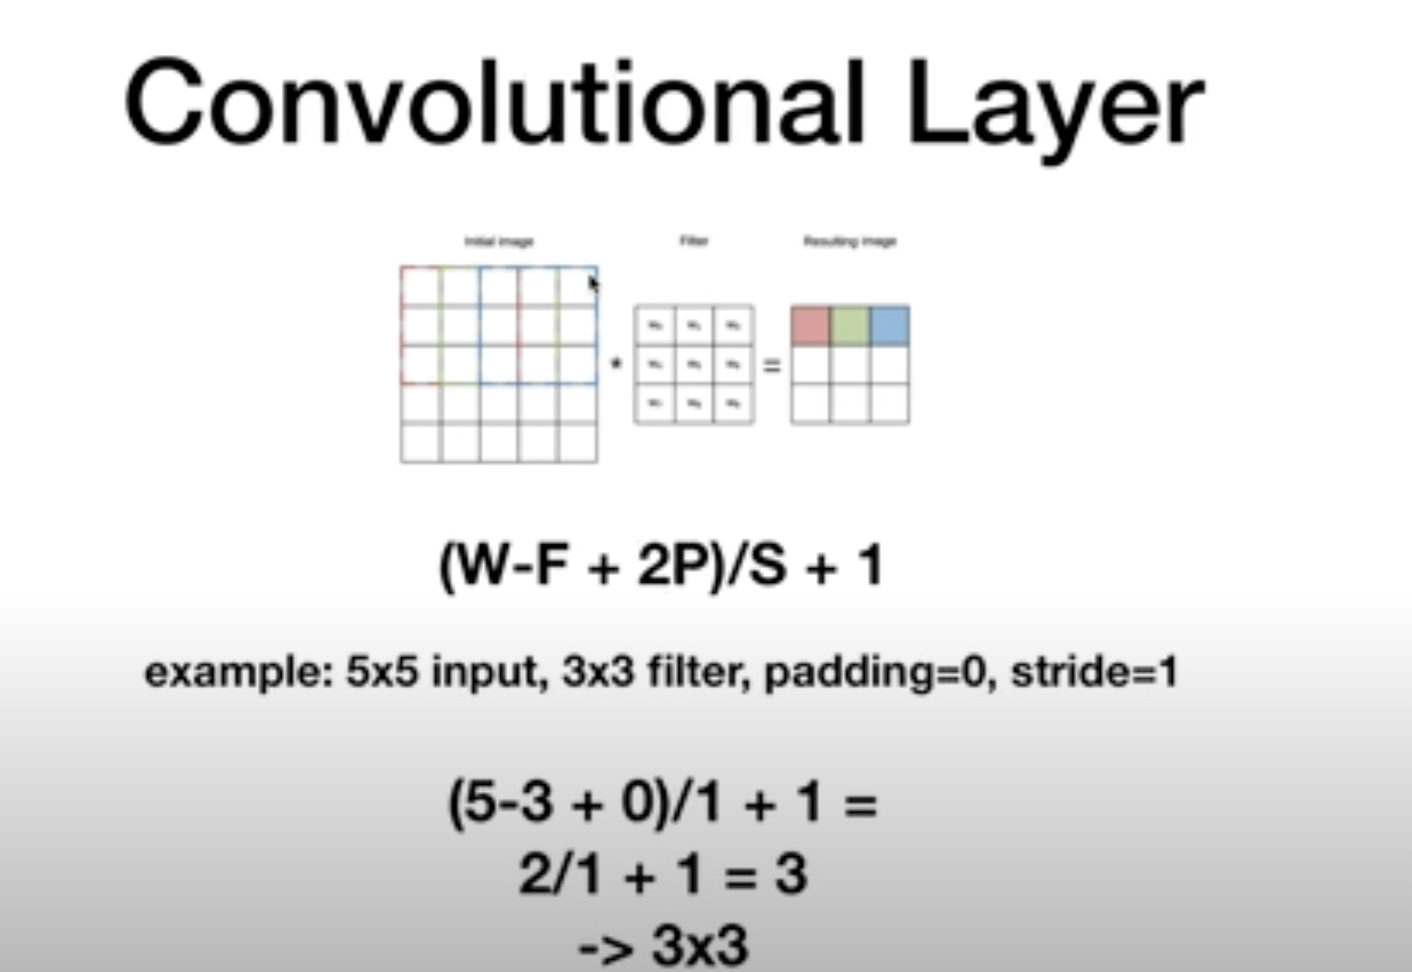

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origunal shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 2000 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], loss: {loss.item():.4f}"
            )

print("Finished Training")

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network : {acc} %")

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of the {classes[i]}: {acc} %")